# Run

### Setup

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW, get_scheduler, GPT2Config
from torch.nn.functional import softmax
import datasets
from datasets import load_dataset, Dataset
import random
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
from torchmetrics import F1Score
pd.options.mode.copy_on_write = True

In [2]:
fpath2 = "/Users/barrychen/Desktop/IELTSWritingHelper/datasets_ready/Task_Achievement.csv"
df2 = pd.read_csv(fpath2)
df2['score'] = df2['score'].round(1)
df_filtered2 = df2[(df2['score'] > 1.5) & (df2['score'] < 12.0)]

reverse_mapping_3 = {
    3.5: 0, 4.0: 0,
    4.5: 1, 5.0: 1,
    5.5: 2, 6.0: 2,
    6.5: 3, 7.0: 3,
    7.5: 4, 8.0: 4,
    8.5: 5, 9.0: 5
}

df_filtered2['score'] = df_filtered2['score'].map(reverse_mapping_3)

df_sampled2 = df_filtered2.groupby('score').sample(
    n=290, 
    random_state=42
).reset_index(drop=True)

df_sampled2['score'] = df_sampled2['score'].astype(int)

dataset2 = Dataset.from_pandas(df_sampled2)

In [3]:
df_sampled2

,prompt,essay,text,score
0,Some people say that to prevent illness and di...,Emerging disease is a complex matter as it IS ...,The candidate has effectively addressed the gi...,0
1,Nowadays celebrities are more famous for their...,"In this present world, famous personalities a...",The essay adequately addresses the task and at...,0
2,More people decided to have children in their ...,"currently, there are more and more people make...",The essay generally addresses the task by disc...,0
3,Many people believe that the current system of...,Once every month no private vehicles a day ca...,The essay fails to address the prompt effectiv...,0
4,Some people think that instead of preventing c...,"In today's time, human activities are having a...",The essay effectively addresses the given task...,0
...,...,...,...,...
1735,some countries more and more people are becomi...,"In many nations, more and more humans are rese...",The essay effectively addresses the given task...,5
1736,Human activities have negative effects on plan...,"Nowadays, industrialisation has increased rapi...",The candidate has effectively addressed the gi...,5
1737,Nowadays people use social media to keep in to...,"In this contemporary era, the hitches allied t...",The candidate has effectively addressed the gi...,5
1738,Many customs and traditional ways of behaviour...,The vibrancy of modern life has led to debates...,The candidate effectively addresses the task b...,5


In [4]:
dataset2

Dataset({
    features: ['prompt', 'essay', 'text', 'score'],
    num_rows: 1740
})

### Fine tune the model

#### Trial #1 (8 labels)

In [5]:
num_labels_2 = 8

# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token
configuration2.num_labels = num_labels_2  # Update the number of labels

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", 
    config=configuration2, 
    ignore_mismatched_sizes=True
).to(device2)

# Tokenization function
def tokenize_function(examples):
    # Concatenate the input columns for each example in the batch
    combined_text = [
        p + " " + e + " " + t for p, e, t in zip(examples["prompt"], examples["essay"], examples["text"])
    ]
    # Tokenize the concatenated text
    return tokenizer2(combined_text, padding="max_length", truncation=True, max_length=1024)

# Tokenize the dataset
tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["prompt", "essay", "text"])
tokenized_datasets2 = tokenized_datasets2.rename_column("score", "labels")
tokenized_datasets2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get the labels from the tokenized dataset
labels2 = tokenized_datasets2["labels"]

# Get the unique labels
unique_labels2 = np.unique(labels2)

# Store the indices for each label
label_to_indices2 = {label: np.where(labels2 == label)[0] for label in unique_labels2}

# Lists to hold the train and validation indices
train_indices2 = []
val_indices2 = []

# For each label, split the indices into train and validation
for label, indices in label_to_indices2.items():
    # Shuffle the indices within each label to ensure random splitting
    np.random.shuffle(indices)
    
    # Split 80% for training, 20% for validation
    split_idx2 = int(0.8 * len(indices))
    train_indices2.extend(indices[:split_idx2])
    val_indices2.extend(indices[split_idx2:])

# Convert indices to tensors
train_indices2 = torch.tensor(train_indices2)
val_indices2 = torch.tensor(val_indices2)

# Create Subsets for train and validation datasets
train_dataset2 = Subset(tokenized_datasets2, train_indices2)
eval_dataset2 = Subset(tokenized_datasets2, val_indices2)

# Dataloaders
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 3
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=num_labels_2, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Harshad018/trained-gpt2-tweet-analysis and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 28%|██▊       | 147/522 [1:44:02<4:23:36, 42.18s/it]

KeyboardInterrupt: 

#### Trial #2 (6 labels)

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at Harshad018/trained-gpt2-tweet-analysis and are newly initialized because the shapes did not match:
- score.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1740 [00:00<?, ? examples/s]

/Users/barrychen/anaconda3/envs/ece1786/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 33%|███▎      | 174/522 [2:06:33<4:31:29, 46.81s/it]

Epoch 1/3: train loss 1.9787, val loss 1.7477, val accuracy 0.1994


 67%|██████▋   | 348/522 [5:05:13<1:27:42, 30.24s/it]  

Epoch 2/3: train loss 1.6406, val loss 1.6834, val accuracy 0.2559


100%|██████████| 522/522 [7:21:07<00:00, 42.23s/it]  

Epoch 3/3: train loss 1.5235, val loss 1.7490, val accuracy 0.2314


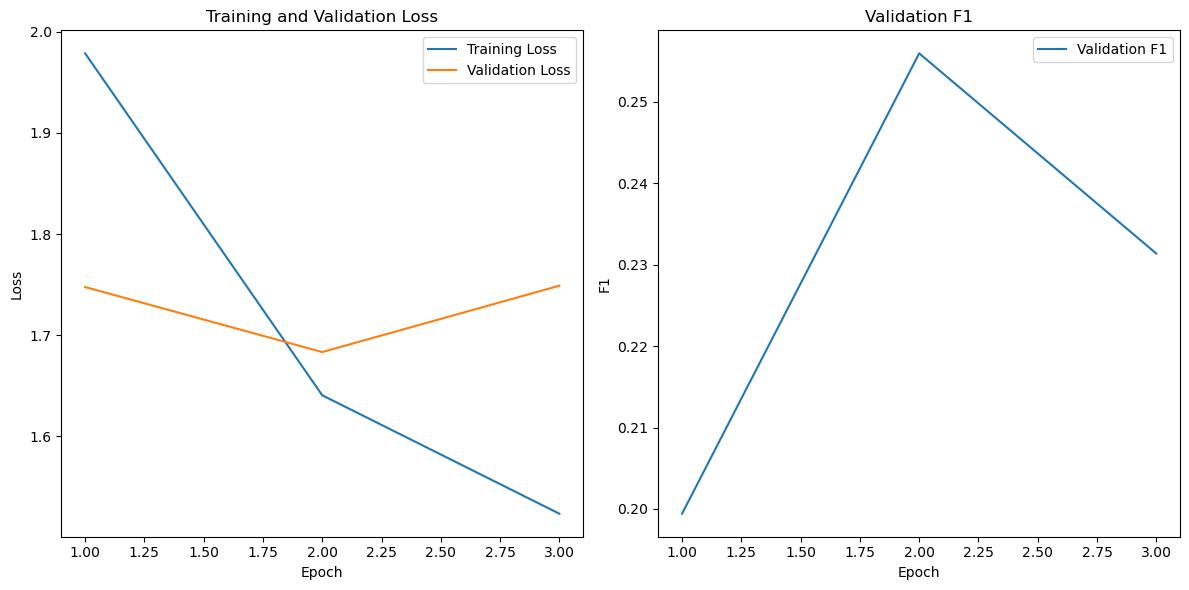

Final validation F1: 0.2314


In [5]:
num_labels_2 = 6

# Move model2 to device (GPU if available)
device2 = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Set up configuration and add pad token ID
configuration2 = GPT2Config.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
configuration2.pad_token_id = configuration2.eos_token_id  # Use eos_token_id as the pad token
configuration2.num_labels = num_labels_2  # Update the number of labels

# Load tokenizer and set pad token
tokenizer2 = GPT2Tokenizer.from_pretrained("Harshad018/trained-gpt2-tweet-analysis")
tokenizer2.pad_token = tokenizer2.eos_token  # Set pad token to eos token

# Load model with configuration
model2 = GPT2ForSequenceClassification.from_pretrained(
    "Harshad018/trained-gpt2-tweet-analysis", 
    config=configuration2, 
    ignore_mismatched_sizes=True
).to(device2)

# Tokenization function
def tokenize_function(examples):
    # Concatenate the input columns for each example in the batch
    combined_text = [
        p + " " + e + " " + t for p, e, t in zip(examples["prompt"], examples["essay"], examples["text"])
    ]
    # Tokenize the concatenated text
    return tokenizer2(combined_text, padding="max_length", truncation=True, max_length=1024)

# Tokenize the dataset
tokenized_datasets2 = dataset2.map(tokenize_function, batched=True)
tokenized_datasets2 = tokenized_datasets2.remove_columns(["prompt", "essay", "text"])
tokenized_datasets2 = tokenized_datasets2.rename_column("score", "labels")
tokenized_datasets2.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Get the labels from the tokenized dataset
labels2 = tokenized_datasets2["labels"]

# Get the unique labels
unique_labels2 = np.unique(labels2)

# Store the indices for each label
label_to_indices2 = {label: np.where(labels2 == label)[0] for label in unique_labels2}

# Lists to hold the train and validation indices
train_indices2 = []
val_indices2 = []

# For each label, split the indices into train and validation
for label, indices in label_to_indices2.items():
    # Shuffle the indices within each label to ensure random splitting
    np.random.shuffle(indices)
    
    # Split 80% for training, 20% for validation
    split_idx2 = int(0.8 * len(indices))
    train_indices2.extend(indices[:split_idx2])
    val_indices2.extend(indices[split_idx2:])

# Convert indices to tensors
train_indices2 = torch.tensor(train_indices2)
val_indices2 = torch.tensor(val_indices2)

# Create Subsets for train and validation datasets
train_dataset2 = Subset(tokenized_datasets2, train_indices2)
eval_dataset2 = Subset(tokenized_datasets2, val_indices2)

# Dataloaders
train_dataloader2 = DataLoader(train_dataset2, shuffle=True, batch_size=8)
eval_dataloader2 = DataLoader(eval_dataset2, batch_size=8)

# Set up optimizer and scheduler
optimizer2 = AdamW(model2.parameters(), lr=1e-5)
num_epochs2 = 3
num_training_steps2 = num_epochs2 * len(train_dataloader2)
lr_scheduler2 = get_scheduler(
    name="linear", optimizer=optimizer2, num_warmup_steps=0, num_training_steps=num_training_steps2
)

model2.to(device2)

# Initialize lists to track training/validation losses and accuracies
train_losses2 = []
val_losses2 = []
val_f1_scores2 = []

# Training loop
progress_bar2 = tqdm(range(num_training_steps2))

# Initialize F1 score metric (weighted-averaged for multi-class classification)
f1_metric2 = F1Score(task="multiclass", num_classes=num_labels_2, average="weighted").to(device2)

for epoch in range(num_epochs2):
    epoch_train_loss = 0
    epoch_val_loss = 0
    f1_metric2.reset()
    model2.train()

    for batch in train_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        outputs = model2(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer2.step()
        lr_scheduler2.step()
        optimizer2.zero_grad()

        epoch_train_loss += loss.item()
        progress_bar2.update(1)

    # Record training loss for the epoch
    train_losses2.append(epoch_train_loss / len(train_dataloader2))

    # Evaluate the model2
    model2.eval()
    for batch in eval_dataloader2:
        batch = {k: v.to(device2) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model2(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        loss = F.cross_entropy(logits, batch["labels"])

        epoch_val_loss += loss.item()
        f1_metric2(predictions, batch["labels"])  # Update F1 metric with predictions

    # Record validation loss and accuracy
    val_losses2.append(epoch_val_loss / len(eval_dataloader2))
    val_f12 = f1_metric2.compute().item()
    val_f1_scores2.append(val_f12)

    print(f"Epoch {epoch + 1}/{num_epochs2}: train loss {train_losses2[-1]:.4f}, val loss {val_losses2[-1]:.4f}, val accuracy {val_f1_scores2[-1]:.4f}")

# Plotting function
def eval_plot(train_losses, val_losses, val_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))

    # Training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_f1_scores, label="Validation F1")
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Validation F1')

    plt.tight_layout()
    plt.show()

# Plot train loss, validation loss, validation accuracy
eval_plot(train_losses2, val_losses2, val_f1_scores2)

# Print final validation accuracy
print(f"Final validation F1: {val_f1_scores2[-1]:.4f}")